<a href="https://colab.research.google.com/github/SaraDornetti/LSN/blob/main/Lezione12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Python Exercise 12 </span>
## <span style="color:orange"> Keras - Deep & Convolutional Neural Network image recognition </span>

Spesso i dataset (specialmente se relativi alla fisica) e task di supervised learning contengono simmetrie e sottostrutture. Per esempio, se l'obiettivo è riconoscere un oggetto in un'immagine, la sua posizione non è importante, di conseguenza il task presenta un'**invarianza sotto traslazioni**. Per sfruttare al meglio queste proprietà sono state create delle reti neurali apposite, le Convolutional Neural Networks (CNNs). Si tratta di reti neurali invarianti sotto traslazioni che rispettano la località dei dati di input. Ci sono due tipi di layer che costituiscono una rete neurale:
- **convolutional layer** calcola la covoluzione dell'input con una serie di filtri.
- **pooling layer** fa coarse graining dell'input mantenendo la località e la struttura spaziale.
Per dati 2D un layer $l$ è caratterizzato da altezza $H_l$, larghezza $W_l$ e numero di canali $D_l$. Altezza e larghezza corrispondono alle dimensioni del piano bidimensionale in termini di neuroni, e.g. il numero di pixel, mentre $D_l$ è il numero di canali in quel layer, e.g. 3 canali per un'immagine RGB.

### MNIST with Keras

The goal of exercise 12 is to use deep neural network models, implemented in the Keras python package, to recognize and distinguish between the ten handwritten digits (0-9).

The MNIST dataset comprises $70000$ handwritten digits, each of which comes in a square image, divided into a $28\times 28$ pixel grid. Every pixel can take on $256$ gradation of the gray color, interpolating between white and black, and hence each data point assumes any value in the set $\{0,1,\dots,255\}$. Since there are $10$ categories in the problem, corresponding to the ten digits, this problem represents a generic **classification task**.

In [ ]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True' #This is needed in my Anaconda+MacOsX installation; leave it commented.
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
seed=0
np.random.seed(seed) # fix random seed (a volte non lo fanno ma è molto importante)
tf.random.set_seed(seed)

#### Step 1: Load and Process the Data

Keras can conveniently download the MNIST data from the web. All we need to do is import the `mnist` module and use the `load_data()` class, and it will create the training and test data sets or us.

The MNIST set has pre-defined test and training sets, in order to facilitate the comparison of the performance of different models on the data.

Once we have loaded the data, we need to format it in the correct shape.

In [ ]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels
# output: numero delle classi di output -> 10 cifre da 0 a 9
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)


#### Example: to_categorical

Converts a class vector (integers) to binary class matrix. E.g. for use with categorical_crossentropy.

In [ ]:
# Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
labels = np.array([0, 2, 1, 2, 0])
# `to_categorical` converts this into a matrix with as many columns as there are classes.
# The number of rows stays the same.
keras.utils.to_categorical(labels)

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

#### Reshape data and convert labels to be used with categorical cross entropy

X_train shape: (60000, 784)
X_test shape: (10000, 784)

An example of a data point with label 4


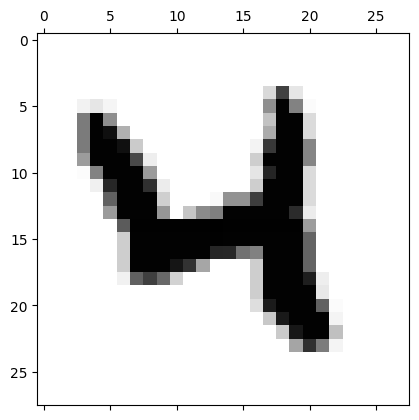

... and with label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


In [ ]:
# Trasformo ciascuna immagine 28x28 in un vettore di 784 componenti. Dunque, prima: X_train.shape = (60000, 28, 28); dopo: X_train.shape = (60000, 784).
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print()

# Tutti i pixel (inizialmente numeri interi tra 0 e 255) vengano trattati come numeri in virgola mobile.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Ogni valore di pixel è diviso per 255, cioè il valore massimo possibile per un pixel in scala di grigi.
# In questo modo i valori dei pixel sono compresi tra 0 e 1.
X_train /= 255
X_test /= 255

# Esempio: viene stampata l’etichetta (cioè la cifra) dell’immagine in posizione 20, e poi viene ricostruita e visualizzata l’immagine corrispondente, usando matshow di Matplotlib.
# X_train[20,:] è il vettore lungo 784 che rappresenta l’immagine in posizione 20.
# .reshape(28,28) lo riporta alla forma originale per poterlo disegnare.

print('An example of a data point with label', Y_train[20])
plt.matshow(X_train[20,:].reshape(28,28),cmap='binary')
plt.show()

# Uso di to_categorical per trasformare le etichette delle cifre da 0 a 9 (necessario per usare la funzione crossentropy come loss).
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('... and with label', Y_train[20], 'after to_categorical')
print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

#### Step 2: Define the Neural Net and its Architecture

We can now move on to construct our deep neural net. We shall use Keras's `Sequential()` class to instantiate a model, and will add different deep layers one by one using the `add()` method

For the purposes of our example, it suffices to focus on `Dense` layers for simplicity. Every `Dense()` layer accepts as its first required argument an integer which specifies the number of neurons. The type of activation function for the layer is defined using the `activation` optional argument, the input of which is the name of the activation function in `string` format. Examples include `relu`, `tanh`, `elu`, `sigmoid`, `softmax`.

In order for our DNN to work properly, we have to make sure that the numbers of input and output neurons for each layer match. Therefore, we specify the shape of the input in the first layer of the model explicitly using the optional argument `input_shape=(N_features,)`. The sequential construction of the model then allows Keras to infer the correct input/output dimensions of all hidden layers automatically. Hence, we only need to specify the size of the softmax output layer to match the number of categories.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_DNN():
    # instantiate model
    model = Sequential()
    # primo layer con 400 neuroni, ciascuno completamente connesso a tutti i 784 input, attivazione è ReLU
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # secondo layer, anche questo completamente connesso, con 100 neuroni e attivazione ReLU
    model.add(Dense(100, activation='relu'))
    # layer di dropout -> disattiva casualmente il 50% dei neuroni durante l’addestramento per evitare overfitting (durante il test o la predizione il dropout è disattivato)
    model.add(Dropout(0.5))
    # Layer denso in cui il numero di neuroni corrisponde al numero di classi (in questo caso 10, cioè le cifre da 0 a 9). Softmax converte l’output in probabilità
    model.add(Dense(num_classes, activation='softmax'))

    return model

print('Model architecture created successfully!')

Model architecture created successfully!


#### Step 3: Choose the Optimizer and the Cost Function

Next, we choose the loss function according to which to train the DNN. For classification problems, this is the cross entropy, and since the output data was cast in categorical form, we choose the `categorical_crossentropy` defined in Keras' `losses` module. Depending on the problem of interest one can pick any other suitable loss function. To optimize the weights of the net, we choose SGD. This algorithm is already available to use under Keras' `optimizers` module, but we could use any other built-in one as well. The parameters for the optimizer, such as `lr` (learning rate) or `momentum` are passed using the corresponding optional arguments of the `SGD()` function. All available arguments can be found in Keras' online documentation at [https://keras.io/](https://keras.io/). While the loss function and the optimizer are essential for the training procedure, to test the performance of the model one may want to look at a particular `metric` of performance. For instance, in categorical tasks one typically looks at their `accuracy`, which is defined as the percentage of correctly classified data points. To complete the definition of our model, we use the `compile()` method, with optional arguments for the `optimizer`, `loss`, and the validation `metric` as follows:

In [ ]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

def compile_model():
    # create the model
    model=create_DNN()
    # compile the model scelgo crossentropy come loss e accuracy come metrica
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adam(),
                  metrics=['acc']) #Come metrica di valutazione si usa l'accuratezza, cioè la percentuale di esempi classificati correttamente durante l’addestramento e la valutazione
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


#### Step 4: Train the model

We train our DNN in minibatches.

Shuffling the training data during training improves stability of the model. Thus, we train over a number of training epochs. Each epoch corresponds to using **all the train data** divided in minibatches.

Training the DNN is a one-liner using the `fit()` method of the `Sequential` class. The first two required arguments are the training input and output data. As optional arguments, we specify the mini-`batch_size`, the number of training `epochs`, and the test or `validation_data`. To monitor the training procedure for every epoch, we set `verbose=True`.

In [ ]:
# training parameters
batch_size = 32
epochs = 50

# create the deep neural net
model_DNN = compile_model()

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          verbose=1,
          validation_data=(X_test, Y_test))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - acc: 0.8528 - loss: 0.4819 - val_acc: 0.9667 - val_loss: 0.1056
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - acc: 0.9618 - loss: 0.1338 - val_acc: 0.9716 - val_loss: 0.0889
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - acc: 0.9728 - loss: 0.0962 - val_acc: 0.9742 - val_loss: 0.0809
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - acc: 0.9796 - loss: 0.0697 - val_acc: 0.9771 - val_loss: 0.0836
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - acc: 0.9832 - loss: 0.0586 - val_acc: 0.9781 - val_loss: 0.0863
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - acc: 0.9842 - loss: 0.0511 - val_acc: 0.9760 - val_loss: 0.0917
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - acc: 0.9874 - loss: 0.0429 - val_acc: 0.9780 - val_loss: 0.0939
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - acc: 0.9879 - loss: 0.0404 - val_acc: 0.9704 - val_loss: 0.1136
Epoch 9/50
1875/1875 ━━━━━━━━━━━

#### Step 5: Evaluate the Model Performance on the *Unseen* Test Data

Next, we evaluate the model and read of the loss on the test data, and its accuracy using the `evaluate()` method.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.9785 - loss: 0.2800

Test loss: 0.21641482412815094
Test accuracy: 0.9821000099182129


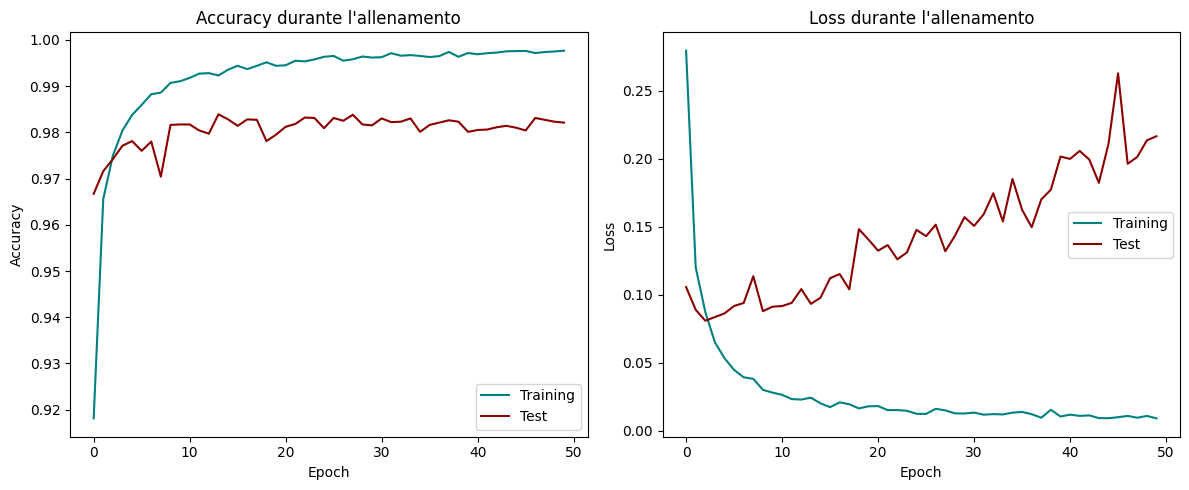

In [ ]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0]) #misura quanto le previsioni del modello si discostano dalla realtà
print('Test accuracy:', score[1]) #ercentuale di esempi classificati correttamente

# look into training history

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# --- Accuracy ---
axs[0].plot(history.history['acc'], color='teal')
axs[0].plot(history.history['val_acc'], color='darkred')
axs[0].set_title("Accuracy durante l'allenamento")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend(["Training", "Test"], loc="best")

# --- Loss ---
axs[1].plot(history.history['loss'], color='teal')
axs[1].plot(history.history['val_loss'], color='darkred')
axs[1].set_title("Loss durante l'allenamento")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend(["Training", "Test"], loc="best")

plt.tight_layout()
plt.show()

Dropout, during training, slices off some artificial neurons, thus, training accuracy suffers. Il test sta funzionando meglio del training perchè sto usando il dropout, se togliessi il dropout avrei un'inversione dell'andamento.

Dropout, during testing, turns itself off and allows all of the ‘weak classifiers’ in the neural network to be used. Thus, testing accuracy improves with respect to training accuracy.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


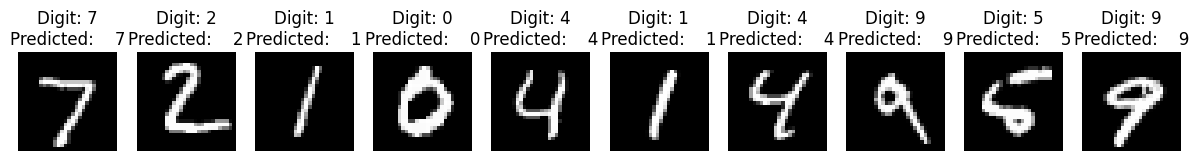

In [ ]:
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15))
for i in range(10): # Mostro le prime 10 immagini e la loro etichetta
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(X_test[i, :, :, 0], cmap='gray')
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))
    plt.axis('off')
plt.show()

### Exercise 12.1

<span style="color:red">Change at will and train your DNN by increasing the number of epochs to an adeuqate value</span>. Try to use at least two other optimizers, different from SGD: <span style="color:red">watch to accuracy and loss for training and validation data and comment on the performances</span>.

La rete neurale è stata costruita nel seguente modo:

- **input layer** con 400 neuroni, ciascuno completamente connesso a tutti i 784 input e funzione di attivazione ReLU
- **hidden layer** completamente connesso, con 100 neuroni e attivazione ReLU
- **layer di dropout** disattiva il 50% dei neuroni durante il training per evitare l'overfitting. Durante il test il dropout è disattivato e il modello usa tutti i neuroni.
- **layer denso** con 10 neuroni (rappresentanti le cifre da 0 a 9), con funzione di attivazione softmax, che converte l’output in probabilità.

La loss scelta è la categorical_crossentropy, particolarmente utilizzata per problemi di classificazione. Il numero di epoche scelto per ottenere valori ragionevoli di loss e accuracy è $N_{epochs}=50$. Per quanto riguarda gli ottimizzatori sono stati utilizzati 3 tipi diversi, analizzati sotto. Per tutti e tre i casi si osservano dei buoni risultati per l'accuracy e la rete è in grado di riconoscere tutte le cifre proposte.



1. **SGD - Stochastic Gradient Descent** Si tratta del più semplice tipo di ottimizzatore. L'idea semplice alla base è quella di aggiornare i pesi seguendo la direzione in cui la loss diminuisce. La dimensione dello step è determinata dal learning rate: se è troppo grande il training è instabile, se è troppo piccolo la convergenza è molto lenta.
- Test loss: 0.05964
- Test accuracy: 0.9834

Dal grafico si osserve una convergenza più lenta, ma risultati abbastanza buoni anche dopo poche epoche. Se l'allenamento procede per un numero abbastanza grande di epoche, i risultati per la test loss e la test accuracy sono migliori rispetto a quelle per gli altri due ottimizzatori usati.

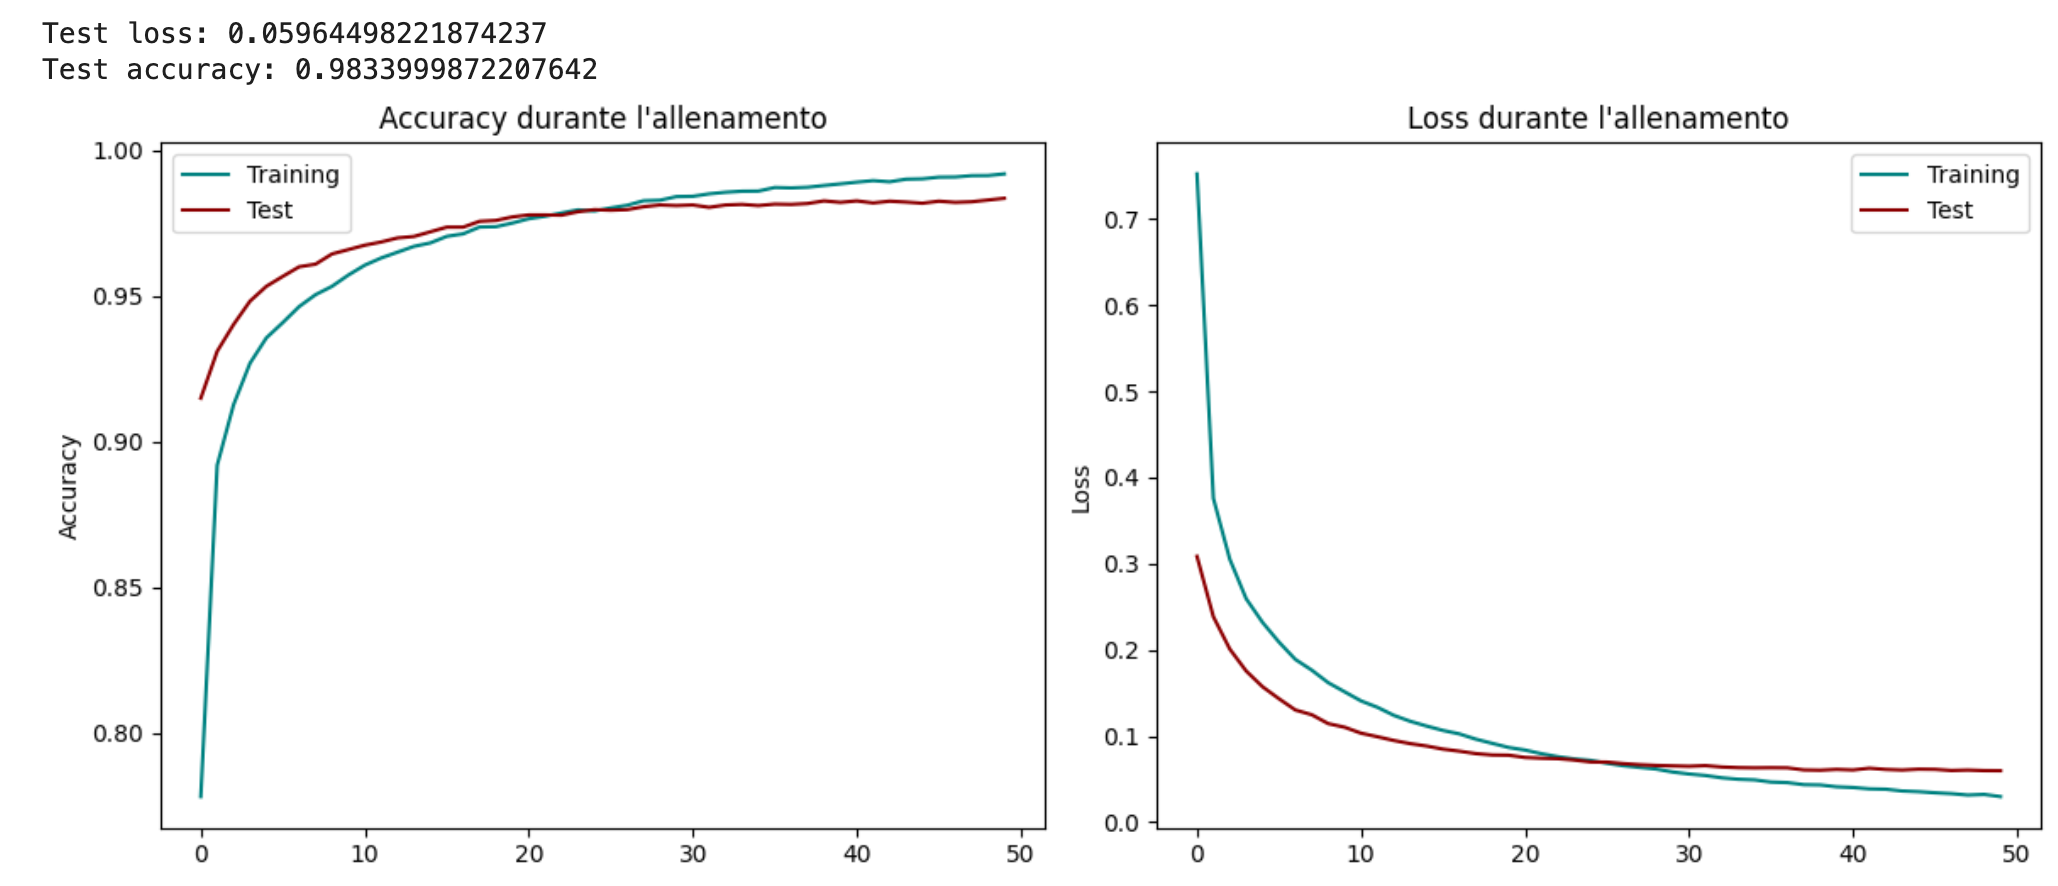


2. **RMSProp** RMSProp adatta automaticamente il learning rate di ogni peso della rete. Mantiene una media mobile dei quadrati dei gradienti; questo permette di capire se un peso ha gradienti molto variabili (rumorosi) o stabili. Se la media è alta, lo step diventa più piccolo; se è bassa, lo step diventa più grande.
- Test loss: 0.2812
- Test accuracy: 0.9795

In questo caso la convergenza è più veloce e si raggiungono alti valori di accuracy dopo poche epoche. La loss è molto piccola ma tende ad avere un andamento più irregolare per i dati di test.

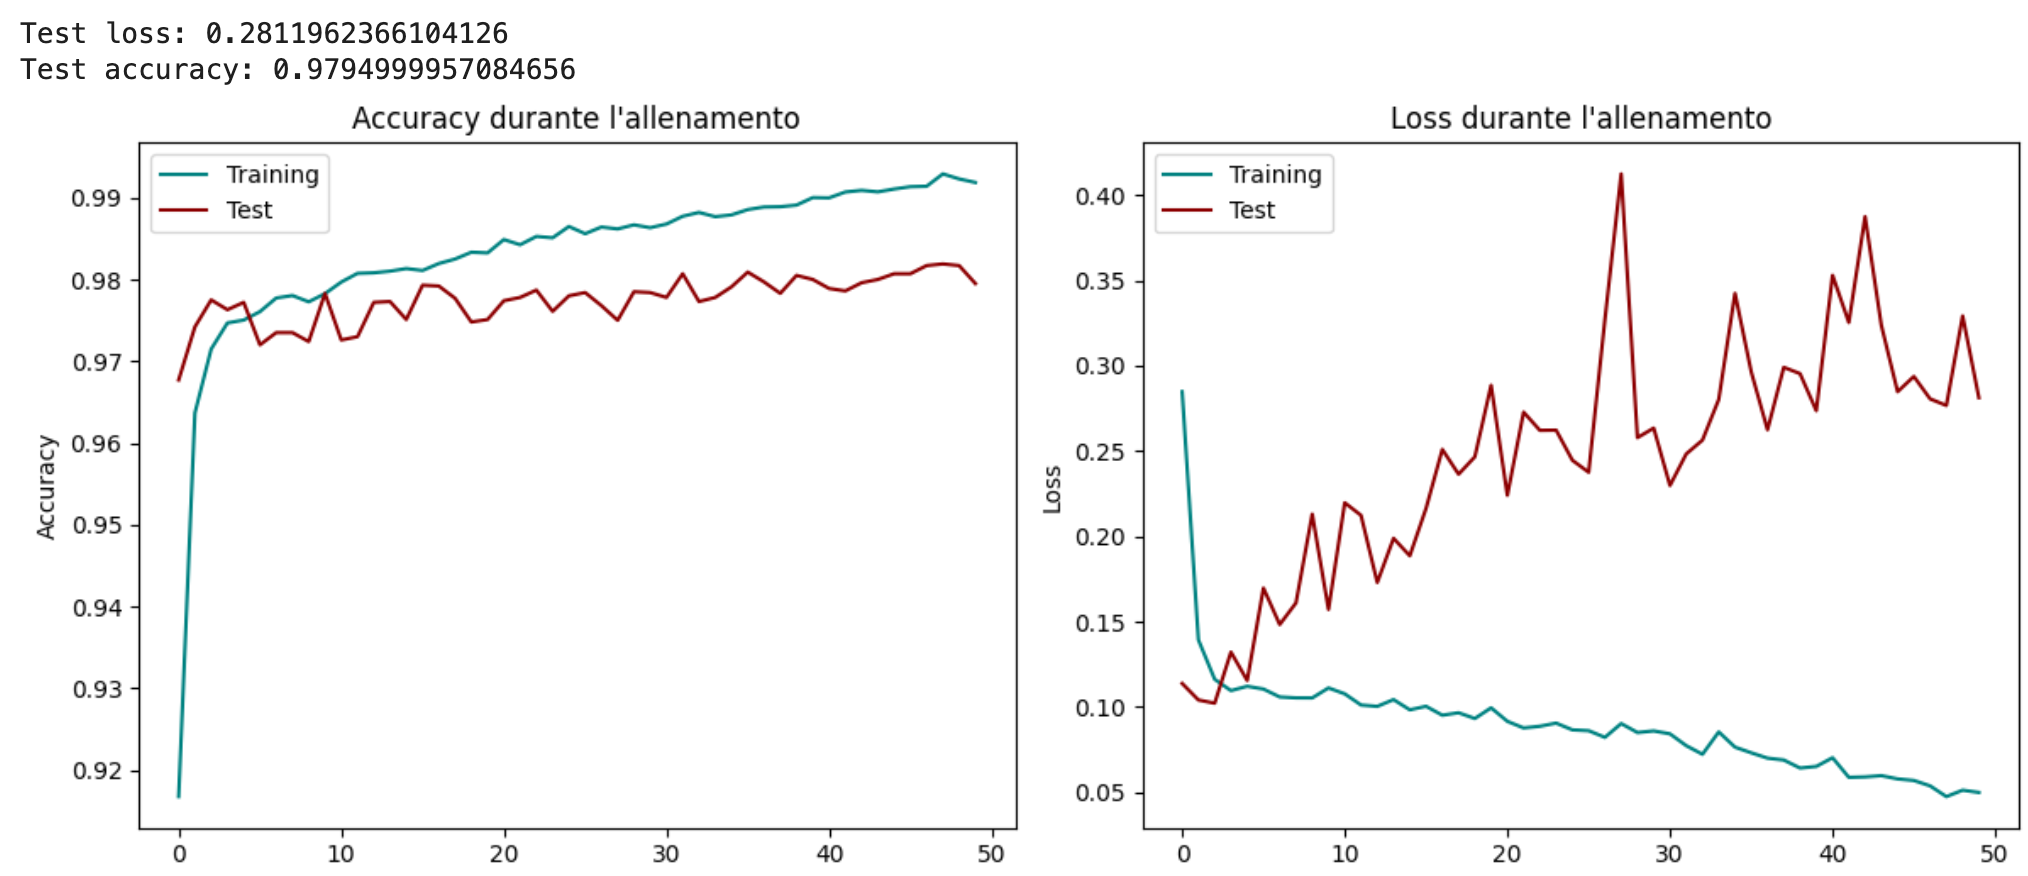


3. **Adam - Adaptive Moment Estimation** Adam calcola la media mobile dei gradienti per capire la direzione dello spostamento e la media mobile dei quadrati dei gradienti per capire quanto è stabile il gradiente. In base a queste due informazioni vengono aggiornati i pesi. Adam converge rapidamente e spesso richiede poche epoche per ottenere ottimi risultati, tuttavia c'è un maggiore rischio di overfitting.
- Test loss: 0.2164
- Test accuracy: 0.9821

Valgono le stesse consiferazioni fatte per RMSProp, anche se in questo caso i risultati sono migliori sia per loss che per accuracy.

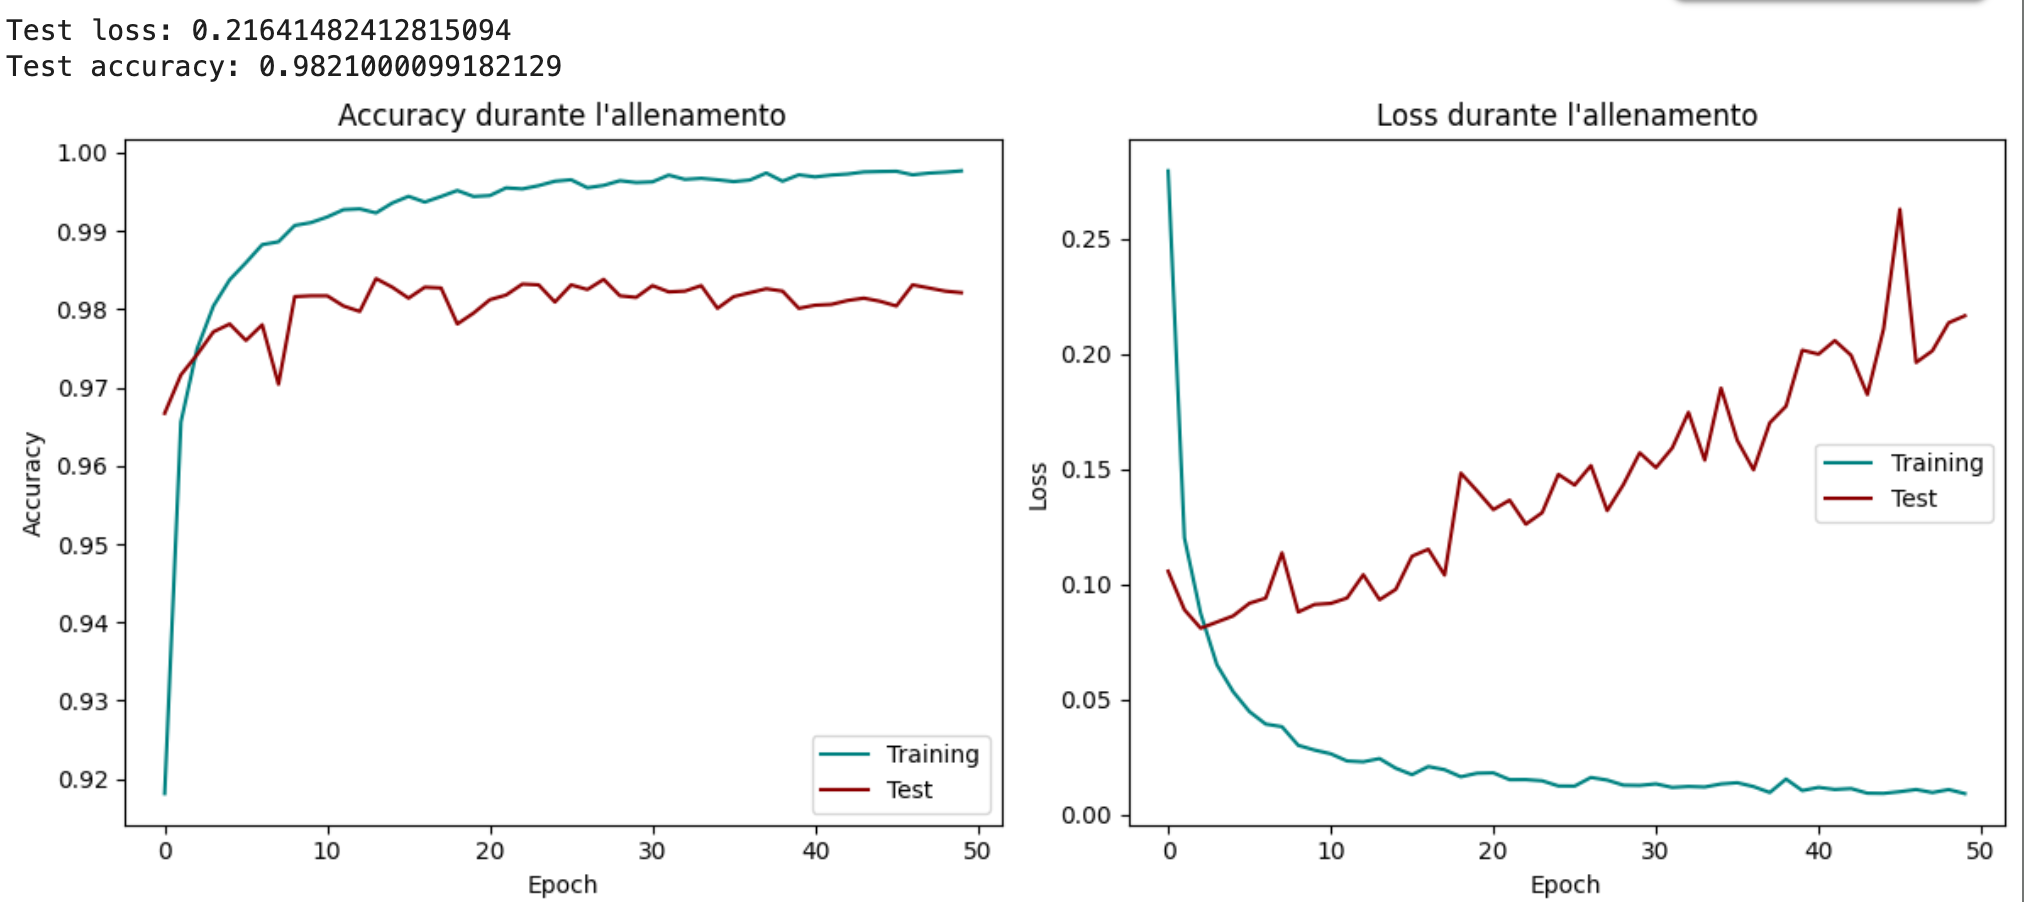

#### Creating Convolutional Neural Nets with Keras

We have so far considered each MNIST data sample as a $(28\times 28,)$-long 1d vector. On the other hand, we do know that in every one of the hand-written digits there are *local* spatial correlations between the pixels, but also *translational invariance*, which we would like to take advantage of to improve the accuracy of our classification model. To this end, we first need to reshape the training and test input data as follows

In [ ]:
# you will need the following for Convolutional Neural Networks
from keras.layers import Flatten, Conv2D, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


One can ask the question of whether a neural net can learn to recognize such local patterns. This can be achieved by using convolutional layers.

### Exercise 12.2

Change the architecture of your DNN using convolutional layers. Use `Conv2D`, `MaxPooling2D`, `Dropout`, but also do not forget `Flatten`, a standard `Dense` layer and `soft-max` in the end. I have merged step 2 and 3 in the following definition of `create_CNN()` that **<span style="color:red">you should complete</span>**:

In [ ]:
def create_CNN():
    # instantiate model
    model = Sequential()
    # primo layer con 6 filtri 5x5, attivazione relu -> introduce nonlinearità
    model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape))


    model.add(MaxPooling2D(pool_size=(2, 2), strides=2)) #Riduce dimensione dell’output di 2
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='SGD',
                  metrics=['acc'])
    return model

Train your DCNN and evaluate its performance proceeding exactly as before:

In [ ]:
# training parameters
batch_size = 32
epochs = 20 # INSERT HERE AN ADEQUATE NUMBER OF EPOCHS!

# create the deep conv net
model_CNN=create_CNN()

# train CNN
model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

# evaluate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - acc: 0.7116 - loss: 0.9308 - val_acc: 0.9516 - val_loss: 0.1612
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - acc: 0.9524 - loss: 0.1571 - val_acc: 0.9677 - val_loss: 0.0987
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - acc: 0.9665 - loss: 0.1130 - val_acc: 0.9768 - val_loss: 0.0753
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - acc: 0.9722 - loss: 0.0930 - val_acc: 0.9793 - val_loss: 0.0657
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - acc: 0.9752 - loss: 0.0804 - val_acc: 0.9815 - val_loss: 0.0587
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - acc: 0.9783 - loss: 0.0711 - val_acc: 0.9830 - val_loss: 0.0538
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - acc: 0.9801 - loss: 0.0638 - val_acc: 0.9838 - val_loss: 0.0504
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - acc: 0.9824 - loss: 0.0580 - val_acc: 0.9848 - val_loss: 0.0469
Epoch 9/20
1875/1875 ━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


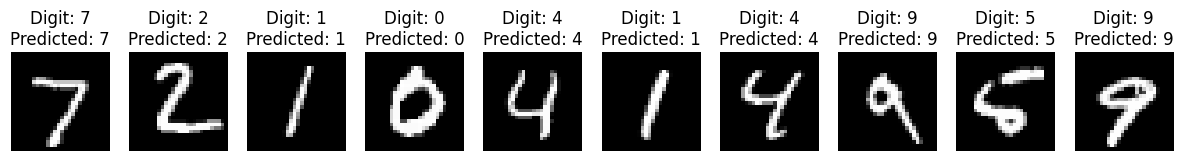

In [ ]:

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols)
predictions = model_CNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(X_test[i, :, :, 0], cmap='gray')
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))
    plt.axis('off')
plt.show()

In the end, **<span style="color:red">add the evaluation of your CNN performances</span>** like that used for the DNN.

Si costruisce una convolutional neural network che segue uno schema composto da livelli convoluzionali, pooling, uno strato completanente connesso e un livello di output con softmax. I livelli sono inseriti in sequenza, uno dopo l'altro.
- Il primo livello convoluzionale usa 6 filtri 5x5. Ogni filtro estrae caratteristiche locali dell'immagine come bordi angoli e texture. Si usa come funzione di attivazione ReLU, che introduce nonlinearità. Input shape definisce la dimensione dell'immagine 28x28.
- Livello di MaxPooling riduce la dimensione dell'immagine di un fattore 2, mantenendo solo il valore massimo in ogni finestra 2x2. Questo permette di ridurre il rumore ed estrarre solo le caratteristiche più importanti.
- Un secondo MaxPooling che riduce ulteriormente la dimensionalità.
- Si usa Flatten per appiattire la struttura 2D in un vettore.
- Strato completamente connesso costituito da 128 neuroni con funzione di attivazione ReLU.
- ultimo strato con attivazione SoftMax, restituisce 10 valori, uno per ogni cifra da 0 a 9, ogni valore è un numero compreso tra zero e uno e sommano a uno (restituisce delle probabilità).

Si usa come loss la categorical crossentropy, adatta a problemi di classificazione e come ottimizzatore lo stochastic gradient descent, semplice e stabile. La metrica è l'accuracy, che misura la percentuale di predizioni corrette.

Si allena il modello per $N_{epochs}=20$ e si ottengono valori di loss e accuracy per i dati di test pari a:
- Test loss: 0.03819647803902626
- Test accuracy: 0.9886000156402588
Inoltre si osserva che la rete predice correttamente tutte le cifre.

### Exercise 12.3

Use the `gimp` application to create 10 pictures of your "handwritten" digits, import them in your jupyter-notebook and try to see if your CNN is able to recognize your handwritten digits.

For example, you can use the following code to import a picture of an handwritten digit
(Note: you should install Python Image Library (PIL/Pillow):

In [ ]:
# TO LOAD FILES ON GOOGLE COLAB

from google.colab import files
import os

for i in range(10):
    filename = f"{i}.png"
    if os.path.exists(filename):
        os.remove(filename)

upload = files.upload()

Saving 0.png to 0.png
Saving 1.png to 1.png
Saving 2.png to 2.png
Saving 3.png to 3.png
Saving 4.png to 4.png
Saving 5.png to 5.png
Saving 6.png to 6.png
Saving 7.png to 7.png
Saving 8.png to 8.png
Saving 9.png to 9.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


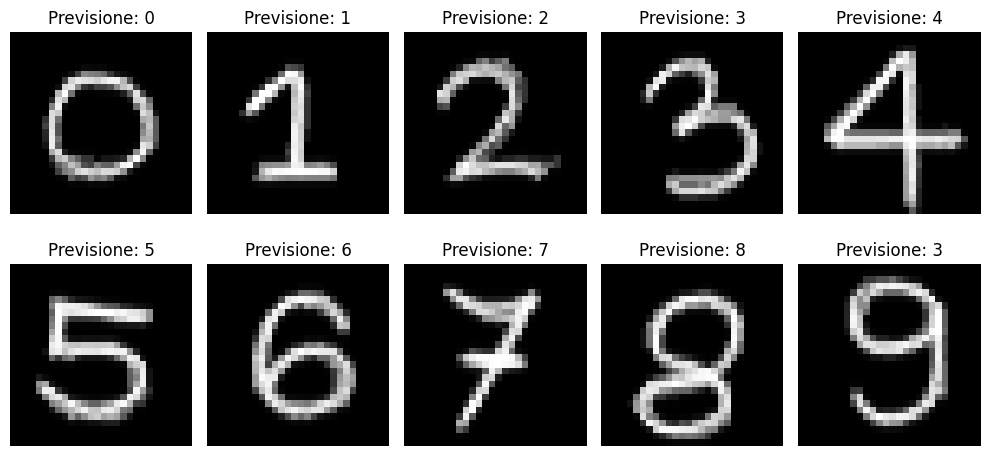

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def predict_digit(filename):
    img = Image.open(filename).convert('L').resize((28, 28))
    data = np.array(img) / 255.0
    data = data.reshape(1, 28, 28).astype(np.float32)
    pred = model_CNN.predict(data)
    pred_digit = np.argmax(pred)
    return img, pred_digit  # Restituisce immagine e predizione

fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i in range(10):
    img, pred = predict_digit(f"{i}.png")
    r = i // 5
    c = i % 5
    axes[r, c].imshow(img, cmap='gray')
    axes[r, c].set_title(f"Previsione: {pred}")
    axes[r, c].axis('off')

plt.tight_layout()
plt.show()

La rete riesce a predire correttamente la maggior parte delle cifre. In particolare, si nota che il numero 3 viene classificato correttamente anche se presenta una certa inclinazione: questo indica che il modello ha imparato caratteristiche sufficientemente robuste da riconoscere la cifra anche quando l’immagine non è perfettamente allineata.

La cifra 9, invece, non viene predetta correttamente. Questo errore potrebbe dipendere dal fatto che la rete è stata addestrata su campioni con una forma leggermente diversa: ad esempio, cifre con linee più dritte e meno “arricciate”. Se la cifra di input presenta una curvatura o uno stile grafico non visto durante il training, il modello può fare confusione con altre classi simili (una situazione analoga si può verificare con il 4 o il 7).

Questo suggerisce che il dataset di addestramento potrebbe non essere abbastanza vario da coprire tutte le possibili varianti stilistiche delle cifre. Quindi un possibile miglioramento si potrebbe ottenere rendendo più vario il dataset di allenamento.

### <span style="color:green">Supplementary information 1: Use of `gimp` </span>

- from the Unix shell type: `gimp` and hit `Return`
- File -> new (chose: 28x28 pixels)
- rascale the image to 800%
- Use the **brush** with dimension 2px to draw your digit
- Color -> invert (to have black background)
- Export the image as a `.png` file

That's all!

### <span style="color:green">Supplementary information 2: Display trained filters in your CNN</span>

Print your NN layers:

In [ ]:
layer_index=0
for layer in model_CNN.layers:
    print(layer_index, layer.name)
    layer_index+=1

Display your filters:

In [ ]:
# layer_index should be the index of a convolutional layer
layer_index=0
# retrieve weights from the convolutional hidden layer
filters, biases = model_CNN.layers[layer_index].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
print(filters.shape)

# plot filters
n_filters, ix = filters.shape[3], 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # specify subplot and turn of axis
    ax = plt.subplot(1,n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :, 0], cmap='gray')
    ix += 1
# show the figure
plt.show()

### <span style="color:green">Supplementary information 3: Monitor layer outputs in your CNN</span>

In [ ]:
test_index = 0

from keras.models import Model
layer_outputs = [layer.output for layer in model_CNN.layers]
activation_model = Model(inputs=model_CNN.input, outputs=layer_outputs)
activations = activation_model.predict(X_test[test_index].reshape(1,28,28,1))

def display_activation(activations, col_size, row_size, layer_index):
    activation = activations[layer_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*3,col_size*3))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

In [ ]:
%matplotlib inline
plt.imshow(X_test[test_index][:,:,0], cmap='gray')
# def display_activation(activations, col_size, row_size, layer number)
display_activation(activations, 4, 2, 0)
# col_size x row_size must be <= Number of filters for the convolutional layer